# Wordle Bot: v1.1.0

---

_Author: Stephen Menary  [Original 11/01/2022,  Last updated 26/01/2022]_

---


## Summary

In this notebook we create a more sophisticated bot, which defines the exploration metric as "the fraction of words we expect to exclude if we guess this word". This has several advantages compared with v1.0.0:
- At every turn it considers how much _additional_ information will be introduced on top of what is already known, and therefore does not give any score to "rediscovering" known information.
- This metric partially accounts for letter position, since it knows which words will be eliminated by learning where a letter is present.
However, there are three disadvantages:
- The expectation value is expensive to compute in the early game, and must therefore be estimated numerically using $N_A$ samples. This still takes longer than v1.0.0, although makes the computation tractable, and it means that the score is not calculated exactly (we can use MC variance to estimate the scale of this problem).
- We still have no concept of "planning ahead", since at every turn the bot guesses whatever word has the highest assigned score. In reality it may be better to form long-term strategies and ultimately optimise the distribution of "expected number of turns until victory" according to your goals (prioritising speed vs winning before turn 7). In principle this distribution can be exactly numerically evaluated but is far too computationally expensive.
- When there are only two-three possible answers left, we may find that several already dis-allowed words have a similar exclusion rate to the words left in the game. In this case it would make sense to prioritise guesses which may be correct.
We therefore introduce an exploitation score which represents "the probability that this answer is correct", and a hyperparameter $\lambda$ which controls the balance between exploration and exploitation. 

We discover the following things:
- The updated exploration metric removes the tail of games which are lost, since we have eliminated information rediscovery. This tail only re-emerges when we choose very suboptimal values for $N_A$ and $\lambda$.
- Generally, $\lambda \sim 0.1-0.5$ works well. At low $\lambda$ values, we do not start guessing possible answers early enough. At high $\lambda$ values, we start guessing possible answers when it would be better to choose a dis-allowed word which provides more information. This is intuitive, because
    - When there is one word left, exploration score is $0$ for all words, so any positive $\lambda$ will result in the correct word being chosen. We therefore do not need to hard-code the policy of choosing an answer when it is the only possibility remaining.
    - When there are two words left, each one will have an exploration score of $0.5$. Other words will have an exploration score of $0.5$ or $0$. However, the allowed words will also have an exploitation score of $0.5$ compared with $0$ for the dis-allowed guesses. We therefore pick randomly from the two allowed answers for any positive $\lambda$ (or alphabetically, which gives identical average results for a uniformly distributed population).
    - When there are three or more words left, there is a balance between exploration and exploitation. The degree to which allowed words are favoured depends on the value of $\lambda$. When $\lambda=0.5$, we naturally balance the probability of being corect with the probability of excluding other words, and select the best word accordingly.
- We find that even small $N_A \in \left[5, 10\right]$ work suprisingly well, presumably because there are a number of high quality words at any step and it is likely that one of them is found at the top of the score distribution. Conversely, all of the low-quality words can be eliminated when only considering a small number of answers. For these reasons, $N_A=20$ already appears close to optimal, with higher values not providing an obvious improvement
- We find that high $\lambda$ is more useful when $N_A$ is very small ($\sim 5$), since guessing an allowed word in later turns is better than guessing based on an inaccurate score estimate. We expect that$\lambda$ will be increasingly useful if we consider possible answers which are weighted according to how common they are. Then we will favour common words over rare ones. We will then 1. prefer to guess common words rather than rare ones due to their exploitation score, and 2. prefer to exclude common words since this maximises the exploration score.

**To balance execution time, probability of winning in fewer than $6$ moves, and the expected number of turns taken to win, we define $N_A=20$ and $\lambda=0.1$ with "AROSE" as an intial guess to be approximately optimal bot settings**

---

## Method details

We define the following three ensembles. Ensemble $\mathbb{W}_\mathrm{all-words}$ is the set of all 5-letter words. Ensemble $\mathbb{W}_\mathrm{allowed}$ is the set of all 5-letter words which have not yet been excluded. Initially this is equal to $\mathbb{W}_\mathrm{allowed}$, but is updated every turn to eliminate any words which are excluded by the total information gathered thus far. Ensemble $\mathbb{W}_\mathrm{guess}$ is the set of all possible guesses. Initially this is equal to $\mathbb{W}_\mathrm{allowed}$, but each word is removed from $\mathbb{W}_\mathrm{guess}$ once it is guessed. *N.B. This was required for bot v1.0.0 to prevent repeatedly choosing the same word, but is not necessary for v1.1.0 because all previously guessed words would naturally be assigned a score of $0$ without any intervention.*

For a possible guess $u \in \mathbb{W}_\mathrm{guess}$, we define the score
\begin{equation}
s\left(u\right) = \lambda \cdot s_\mathrm{exploit}\left(u\right) ~+~ \left(1-\lambda\right) \cdot s_\mathrm{explore}\left(u\right)
\end{equation}
as a weighted sum of exploitation and exploration terms where 
\begin{equation}
s_\mathrm{exploit}\left(u\right) ~= \begin{cases} 0 &\text{if $u$ ruled out} \\ \frac{1}{N_\mathrm{allowed}} &\text{otherwise}\\ \end{cases}
\end{equation}
is the estimated probability of a word having being selected as the answer based on what we know, which is a constant because our environment selects the answer from a uniform distribution, and $N_\mathrm{allowed}$ is the number of possible answers remaining, and
\begin{equation}
s_\mathrm{explore}\left(u\right) ~= \mathbb{E}_{\mathrm{v,w}\in\mathbb{W}_\mathrm{allowed}} \left[ p\left(\mathrm{exclude}~v~|~ \mathrm{true}~w,~\mathrm{guess}~u\right) \right] 
\end{equation}
where $p\left(\mathrm{exclude}~v~|~ \mathrm{true}~w,~\mathrm{guess}~u\right)$ is the probability that word $v$ is excluded given that word $w$ was true and we guessed $u$. This term tells us what fraction of all remaining allowed words we expect to eliminate if we guess $u$.

If there are $N_\mathrm{allowed}$ words remaining, computing this expectation value exactly is $O\left(N_\mathrm{allowed}^2\right)$ complexity. Since we must evaluate this expectation for all $N_\mathrm{guess} \sim 3000$ possible guesses, the total complexity is $O\left(N_\mathrm{guess}N_\mathrm{allowed}^2\right)$. At the start of the game when $N_\mathrm{allowed} \sim 3000$, this is prohibitively expensive. Even later in the game when $100 < N_\mathrm{allowed} < 500$ it maybe still be very slow. Instead we estimate this expectation using a random subset of $N_A$ words from $\mathbb{W}_\mathrm{allowed}$.

There are therefore $2$ hyperparameters associated with our model: the factor $\lambda$ which balances exploitation versus exploration, and $N_A$ which controls the accuracy of the MC estimate for $s_\mathrm{explore}\left(u\right)$. At every turn, the policy is to choose the word which maximises the score. If only one word remains in $\mathbb{W}_\mathrm{allowed}$, the answer is known and this is chosen instead.

Note that we still do not have any concept of "planning ahead", and instead try to choose the optimal move at every turn, where optimality is defined by the score function. Since computing the score at the first step takes a long time, we will continue using 'AROSE' as the guess at the first turn. This is because the guess at the first turn is the same for all games, and when using $N_A=500$ we find that it lies close to the top of the score ranking so is considered to be a good choice by the algorithm.

---

##  Implementation

We will now implement the bot and run the experiments

In [1]:
###################################
###  Import required libraries  ###
###################################

import sys, time

import numpy as np
import pickle
from matplotlib import pyplot as plt

#  English words are defined using the english_words package
from english_words import english_words_set


In [2]:
#################################
###  Define global constants  ###
#################################
#
#  Define how many words we will consider
#
num_words = -1

#
#  Define an allowed alphabet of allowed letters
#  We work in an environment where they all letters are upper case
#
alphabet = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N" \
           , "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z"]

#  Define a function to verify that a word provided is length 5 and contains only allowed letters  
#
is_valid_word = lambda word : True if (len(word)==5 and np.sum([(letter in alphabet) for letter in word.upper()]) == 5) else False

#  Create a list of all 5-letter words from english_words_set
#
all_words = [w.upper() for w in english_words_set if len(w) == 5 and is_valid_word(w)]
if num_words > 0 and num_words < len(all_words) :
    np.random.seed(num_words)
    all_words = list(np.random.choice(all_words, size=(num_words,), replace=False))
    if "RAISE" not in all_words :
        del all_words[-1]
        all_words.append("RAISE")
    all_words = sorted(all_words)
print(f"{len(all_words)} five letter words found")


3194 five letter words found


In [3]:
################################
###  Define in-game methods  ###
################################
#
#  These methods are used to set up and play a game of Wordle
#

def initialise_possible_guesses() :
    '''Returns list of all possible guesses at the game start'''
    return sorted([w for w in all_words])

def initialise_possible_answers() :
    '''Returns list of all possible answers at the game start'''
    return sorted([w for w in all_words])
    
def remove_guess_from_possible_list(possible_guesses, guess_word, force_present=False) :
    '''Remove guess_word from the mutable list possible_guesses (require word to be present if force_present=True)'''
    if force_present and guess_word not in possible_guesses :
        raise ValueError(f"Guess '{guess_word}' not in possible_guesses list of length {len(possible_guesses)}")
    del possible_guesses[possible_guesses.index(guess_word)]

def guess(true_word, guess_word, possible_guesses=None) :
    '''Return the constraints learned by guessing guess_word if true_word is true.
       If mutable list possible_guesses is provided, remove guess_word from it'''
    # Initialise return containers. Constraints are:
    #  1. correct_spaces   = letters known to be in these positions
    #  2. incorrect_spaces = letters known to not be in these positions
    #  3. correct_letters  = letters known to be present in addition to any in correct_spaces, but position unknown
    #  4. absent_letters   = letters known to be absent, other than any in correct_spaces
    correct_spaces, incorrect_spaces, correct_letters, absent_letters = [], [], [], []
    #  For every letter index, check if letters match. Store the results in correct_spaces and incorrect_spaces
    remove_idcs_from_word, reduced_guess_letters = [], []
    for l_idx, (tl, gl) in enumerate(zip(true_word, guess_word)) :
        if tl != gl :
            reduced_guess_letters.append(gl)
            incorrect_spaces.append((l_idx, gl))
            continue
        correct_spaces.append((l_idx, gl))
        remove_idcs_from_word.append(l_idx)
    #  Create a "reduced word" which does not include the known letters already confirmed to be correctly placed
    reduced_true_word = true_word
    for l_idx in remove_idcs_from_word[::-1] :
        reduced_true_word = reduced_true_word[:l_idx] + reduced_true_word[1+l_idx:]
    #  For any letters which were not correctly placed, ask whether they are present somewhere else
    #  - when one is found, remove it from the reduced word to prevent it being counter again
    #  - if letter found, store in correct_letters, otherwise store in absent_letters
    for guess_letter in reduced_guess_letters :
        guess_letter_idx = reduced_true_word.find(guess_letter)
        if guess_letter_idx >= 0 :
            correct_letters.append(guess_letter)
            reduced_true_word = reduced_true_word[:guess_letter_idx] + reduced_true_word[1+guess_letter_idx:]
        else :
            absent_letters.append(guess_letter)
    #  Remove repetitions in absent_letters
    absent_letters = set(absent_letters)
    #  If a list of possible_guesses, remove the word we have now guessed
    if type(possible_guesses) != type(None) :
        remove_guess_from_possible_list(possible_guesses, guess_word)
    #  Return the constraint containers we have populated
    return [correct_spaces, incorrect_spaces, correct_letters, absent_letters]


In [4]:
################################
###  Define in-game methods  ###
################################
#
#  Further methods used to set up and play a game of Wordle
#

def update_constraints(old_constraints, new_constraints) :
    '''Return a set of constraints obtained by merging old_constraints and new_constraints'''
    # Separate the different constraint containers, and create new tmp_ version to store the combined versions
    old_correct_spaces, old_incorrect_spaces, old_correct_letters, old_absent_letters = old_constraints[0], old_constraints[1], old_constraints[2], old_constraints[3]
    new_correct_spaces, new_incorrect_spaces, new_correct_letters, new_absent_letters = new_constraints[0], new_constraints[1], new_constraints[2], new_constraints[3]
    tmp_correct_spaces, tmp_incorrect_spaces, tmp_correct_letters, tmp_absent_letters = [], [], [], []
    # Combine incorrect_spaces containers, which is just the union of the two separate versions
    tmp_incorrect_spaces = [item for item in old_incorrect_spaces]
    for (idx, letter) in new_incorrect_spaces :
        if (idx, letter) in old_incorrect_spaces : continue
        tmp_incorrect_spaces.append((idx, letter))
    tmp_incorrect_spaces.sort(key = lambda v: v[0])
    # Combine correct_spaces containers, which is also the union of the two separate versions
    tmp_correct_spaces   = [item for item in old_correct_spaces  ]  
    for (idx, letter) in new_correct_spaces :
        if (idx, letter) in old_correct_spaces : continue
        tmp_correct_spaces.append((idx, letter))
    # Combine correct_letters: this is more difficult because we need to account for any letters present in
    #   the correct_spaces container. We note that some letters may need to be moved from old_correct_letters
    #   to tmp_correct_spaces. Furthermore, a letter in new_correct_letters may already be present in
    #   old_correct_spaces and not need to be copied forwards. We resolve this mess by simply counting the total
    #   number of times the letter is green/yellow in both the old and new containers, count how many times the
    #   letter is green in the combined container, and assign anything remaining to the combined yellow container
    tmp_correct_letters = []
    for letter in set(new_correct_letters + old_correct_letters) :
        num_times_in_new_answer  = len([True for l in new_correct_letters if l==letter]) + len([True for (i,l) in new_correct_spaces if l==letter])
        num_times_in_old_answer  = len([True for l in old_correct_letters if l==letter]) + len([True for (i,l) in old_correct_spaces if l==letter])
        num_times_in_corr_spaces = len([True for (i,l) in tmp_correct_spaces if l==letter])
        num_times_expected       = np.max([num_times_in_new_answer, num_times_in_old_answer]) - num_times_in_corr_spaces
        for i in range(num_times_expected) : tmp_correct_letters.append(letter)
    # Combine absent_letters containers, which is also the union of the two separate versions
    tmp_absent_letters = [item for item in old_absent_letters  ]
    for letter in new_absent_letters :
        if letter not in tmp_absent_letters : tmp_absent_letters.append(letter)
    # Return combined constraints       
    return [tmp_correct_spaces, tmp_incorrect_spaces, tmp_correct_letters, tmp_absent_letters]
            
def get_expected_num_answers_excluded_by_guess(guess_word, possible_answers, old_constraints) :
    '''Return expectation value of fraction of list possible_answers excluded if we guess guess_word
       Account for existing knowledge contained in old_constraints'''
    # Create container for num_possible_answers which remain after we guess guess_word
    num_possible_answers = []
    # For every entry in possible_answers, assume this is the true word, then
    #  1. obtain the constraints learned by guessing guess_word
    #  2. combine these constraints with the knowledge we already have
    #  3. ask "what fraction of possible_answers are excluded by these combined constraints"
    #  4. add this fraction to num_possible_answers
    for possible_answer in possible_answers :
        new_constraints   = guess(possible_answer, guess_word)
        total_constraints = update_constraints(old_constraints, new_constraints)
        num_possible_answers.append(len(filter_possible_answers(possible_answers, total_constraints))/len(possible_answers))
    # Return 1 - mean(num_possible_answers), as well as the standard error in case this was a random sampling
    return (1-np.mean(num_possible_answers), np.std(num_possible_answers)/np.sqrt(len(num_possible_answers)))

def get_word_scores_v1(possible_guesses, possible_answers, current_constraints, Na=-1, verbose=True, exploit_factor=0) :
    '''Return a list of the scores associated with every guess in possible_guesses
       - score(u) = lambda x s_exploit(u) + (1 - lambda) x s_explore(u)
       - hyperparameter lambda = exploit_factor
       - assume only answers in possible_answers are possible
       - calculate s_explore using only Na random samples if Na>0 and less than the length of possible_answers'''
    # Initialise return container word_scores as a list (not a dictionary so we can sort it reliably)
    word_scores = []
    # If using a sampling, populate reduced_possible_answers with Na exclusive samples of possible_answers
    #  otherwise use reduced_possible_answers = possible_answers to calculate s_explore exactly
    reduced_possible_answers = possible_answers
    if (Na>0) and (Na<len(possible_answers)) :
        np.random.seed(Na)
        reduced_possible_answers = np.random.choice(possible_answers, size=(Na,), replace=False)
    # Loop of all possible guesses, calculate and save the score for each
    for word_idx, guess_word in enumerate(possible_guesses) :
        if verbose : sys.stdout.write(f"\rGetting score for word {1+word_idx} / {len(possible_guesses)}: {guess_word}")
        explore_score = get_expected_num_answers_excluded_by_guess(guess_word, reduced_possible_answers, current_constraints)
        exploit_score = 1./len(possible_answers) if guess_word in possible_answers else 0.
        total_score   = exploit_factor*exploit_score + (1.-exploit_factor)*explore_score[0]
        word_scores.append((guess_word, total_score, (1.-exploit_factor)*explore_score[1]))
    if verbose : sys.stdout.write("\n")
    # Sort the words according to their score
    word_scores.sort(key=lambda w : w[1], reverse=True)
    # Return word_scores 
    return word_scores
    
def filter_possible_answers(possible_answers, constraints=[[], [], [], []], verbose=False) :
    '''Return a list of all entries from possible_answers which satisfy the given constraints'''
    # Separate constraints into individual containers
    correct_spaces, incorrect_spaces, correct_letters, absent_letters = constraints[0], constraints[1], constraints[2], constraints[3]
    # Create return list
    tmp_possible_answers = []
    # Loop over all initially possible answers and add them to tmp_possible_answers only if they
    #  satisfy all of the provided constraints
    for possible_answer in possible_answers :
        # Use bool is_possible to check result of inner loops
        is_possible = True
        # Set is_possible to False and exit outer loop if any known spaces are not satisfied by possible_answer
        for (idx, letter) in correct_spaces :
            if possible_answer[idx] != letter :
                if verbose :
                    print(f"{possible_answer} failed because it doesn't have an {letter} at index {idx}")
                is_possible = False
        if not is_possible : continue
        # Set is_possible to False and exit outer loop if any known "letter is not here" spaces are not satisfied by possible_answer
        for (idx, letter) in incorrect_spaces :
            if possible_answer[idx] == letter :
                if verbose :
                    print(f"{possible_answer} failed because it has an {letter} at index {idx}")
                is_possible = False
        if not is_possible : continue
        # Create a "reduced word" which does not include the letters already verified
        remove_idcs_from_word = sorted([idx for (idx,letter) in correct_spaces])
        reduced_possible_answer = possible_answer
        for l_idx in remove_idcs_from_word[::-1] :
            reduced_possible_answer = reduced_possible_answer[:l_idx] + reduced_possible_answer[1+l_idx:]
        # Set is_possible to False and exit outer loop if any known letters are not present in reduced word
        #  If a letter is found, remove it from reduced word to prevent double counting
        for correct_letter in correct_letters : 
            l_idx = reduced_possible_answer.find(correct_letter)
            if l_idx < 0 :
                if verbose :
                    print(f"{possible_answer} failed because it doesn't have an {correct_letter} (reduced word is {reduced_possible_answer})")
                is_possible = False
            else :
                reduced_possible_answer = reduced_possible_answer[:l_idx] + reduced_possible_answer[1+l_idx:]
        if not is_possible : continue
        # Set is_possible to False and exit outer loop if any absent letters are present in reduced word
        for absent_letter in absent_letters :
            if absent_letter in reduced_possible_answer :
                if verbose :
                    print(f"{possible_answer} failed because it has an {absent_letter} (reduced word is {reduced_possible_answer})")
                is_possible = False
        if not is_possible : continue
        # If a word makes it this far, it has not been excluded by known constraints so we add it to return list
        tmp_possible_answers.append(possible_answer)
    # return list of allowed answers
    return tmp_possible_answers


In [5]:
#######################################################################
###  Define method to print graphic summarising wordle performance  ###
#######################################################################
#

def get_blocks_from_new_constraints(new_constraints) :
    '''Return a str representing the unicode blocks summarising the constraints provided'''
    B, G, Y = "⬛", "🟩", "🟨"
    blocks = [B, B, B, B, B]
    for c in new_constraints[0] :
        blocks[c[0]] = G
    letters_present = [l for l in new_constraints[2]]
    for c in new_constraints[1] :
        idx, letter = c[0], c[1]
        if letter not in letters_present : continue
        del letters_present[letters_present.index(letter)]
        blocks[idx] = Y
    return blocks

In [6]:
#################################################################
###  Define method to play a Wordle using the given settings  ###
#################################################################
#
#  These methods are used to set up and play a game of Wordle
#

def play_game(game_label="", first_word=None, true_word=None, Na=-1, verbose=True, exploit_factor=0., n_print_score=4) :
    '''Play a game of Wordle and return (number of turns, time taken) to complete
       - If first_word is provided, guess this word on turn 1
       - If true_word is provided, force this to be the true word, otherwise sample from all_words
       - Na and lambda=exploit_factor are the bot hyperparameters'''
    #
    # Select the true word
    #    randomly sample this from all_words if one is not provided
    #
    if type(true_word) != str :
        true_word = np.random.choice(all_words, size=(1,))[0].upper()
    else :
        true_word = true_word.upper()
        assert len(true_word) == 5
    #
    # Print a message if verbose selected
    #
    if verbose :
        print_line = f"---  BEGIN GAME {game_label}: WORD IS '{true_word}' ---"
        print("-"*len(print_line))
        print(print_line)
        print("-"*len(print_line))
    #
    # Record the game start time
    #
    start_time = time.time()
    #
    # Create initially unconstrained lists of possible guesses and answers
    #
    possible_guesses = initialise_possible_guesses()
    possible_answers = initialise_possible_answers()
    #
    # Keep track of the turn_count and total_constraints throughout game
    #
    turn_count, total_constraints = 0, [[], [], [], []]
    #
    # Keep taking turns until guess_word is correct!
    #
    record, guess_word = "", ""
    while guess_word != true_word :
        turn_count += 1
        if verbose : print(f"\nTurn {turn_count}")
        #
        # Select a guess word
        #    - on turn 1, choose first_word if configured to do so
        #    - if only one possible answer remains then select it (only required for lambda=0)
        #    - otherwise compute the word scores for every possible guess and select the top entry
        #
        if turn_count == 1 and type(first_word) is str:
            assert is_valid_word(first_word), f"{first_word.upper()} is not a valid first word"
            guess_word = first_word.upper()
        elif len(possible_answers) == 1 :
            guess_word = possible_answers[0]
        else :
            word_scores = get_word_scores_v1(possible_guesses, possible_answers, total_constraints, Na=Na, verbose=verbose, exploit_factor=exploit_factor)
            max_score   = np.max([s for (w,s,us) in word_scores])
            top_words   = [w for (w,s,us) in word_scores if s > max_score - 1e-5]
            np.random.seed(len(word_scores)+int(1000*max_score))
            guess_word  = np.random.choice(top_words)
            if verbose : print("Top words are:\n  " + "\n  ".join([f'{idx+1}. {w} ({s:.4f} +- {us:.4f})' for idx,(w,s,us) in enumerate(word_scores[:min(len(word_scores),n_print_score)])]))
        #
        # If guess_word is correct, we win!
        #    otherwise derive the constraints we learn from the guess, and update total_constraints accordingly
        #    this removes the guess from the list of possible_guesses
        #    we then remove any now-excluded words from possible_answers
        #
        if verbose : print(f"Guessing word {guess_word.upper()}")
        if guess_word != true_word :
            new_constraints   = guess(true_word, guess_word, possible_guesses)
            total_constraints = update_constraints(total_constraints, new_constraints)
            possible_answers  = filter_possible_answers(possible_answers, total_constraints)
            if verbose : 
                print(f"{len(possible_guesses)} possible guesses remain")
                print(f"{len(possible_answers)} possible answers remain")
                record += "".join(get_blocks_from_new_constraints(new_constraints)) + "\n"
    #
    # Compute time taken to complete game and print victory message
    #
    end_time = time.time()
    if verbose :
        print(f"SUCCESS IN {turn_count} TURNS and {end_time-start_time:.2f}s\n")
        record += "🟩🟩🟩🟩🟩"
        print(f"Wordlebot {game_label} {turn_count}/6\n")
        print(record)
    #
    # Return turn_count and elapsed time
    #
    return turn_count, end_time-start_time


In [7]:
################################
###  Play a game of wordle!  ###
################################

play_game(Na=20, exploit_factor=0.5, first_word="RAISE")
    

-------------------------------------
---  BEGIN GAME : WORD IS 'LIKEN' ---
-------------------------------------

Turn 1
Guessing word RAISE
3193 possible guesses remain
54 possible answers remain

Turn 2
Getting score for word 3193 / 3193: ZOMBA
Top words are:
  1. DEVIL (0.4668 +- 0.0050)
  2. BETEL (0.4650 +- 0.0027)
  3. DEBIT (0.4643 +- 0.0049)
  4. INLET (0.4643 +- 0.0038)
Guessing word DEVIL
3192 possible guesses remain
6 possible answers remain

Turn 3
Getting score for word 3192 / 3192: ZOMBA
Top words are:
  1. FILET (0.4722 +- 0.0160)
  2. INLET (0.4722 +- 0.0160)
  3. LIKEN (0.4722 +- 0.0160)
  4. LINEN (0.4722 +- 0.0160)
Guessing word LINEN
3191 possible guesses remain
1 possible answers remain

Turn 4
Guessing word LIKEN
SUCCESS IN 4 TURNS and 8.22s

Wordlebot  4/6

⬛⬛🟨⬛🟨
⬛🟨⬛🟨🟨
🟩🟩⬛🟩🟩
🟩🟩🟩🟩🟩


(4, 8.21896505355835)

In [8]:
#################################################################################################
###  Find out what the best initial words to use are, based on expected num. states excluded  ###
#################################################################################################

def print_best_initial_words(n_print_score=4, Na_values=[100, 500, -1], reduce_factor=0.2) :
    '''Print the best n_print_score initial words by iteratively estimating scores using the
       Na values in Na_values and reducing the list of possibilities by a factor of reduce_factor'''
    #
    # Create initially unconstrained lists of possible guesses and answers
    #
    possible_guesses = initialise_possible_guesses()
    possible_answers = initialise_possible_answers()
    #
    #  Iteratively estimate best words using Na values in Na_values
    #  - at each step, reduce the length of possible words by a factor of reduce_factor
    #  - this discards words which are estimated to be rubbish, so we don't bother evaluating with larger Na values
    #
    for Na in Na_values :
        print(f"Running iteration Na={Na} with {len(possible_guesses)} possible guesses")
        word_scores = get_word_scores_v1(possible_guesses, possible_answers, [[],[],[],[]], Na=Na, verbose=True, exploit_factor=0.)
        print("Top words are:\n  " + "\n  ".join([f'{idx+1}. {w} ({s:.4f} +- {us:.4f})' for idx,(w,s,us) in enumerate(word_scores[:min(len(word_scores),n_print_score)])]))
        reduce_idx = int(reduce_factor*len(word_scores))
        print(f"Cutting at word {word_scores[reduce_idx][0]} with score {word_scores[reduce_idx][1]:.4f} +- {word_scores[reduce_idx][2]:.4f}")
        possible_guesses = [w for (w,s,es) in word_scores[:reduce_idx]]

# Print the 9 best words
print_best_initial_words(9)


Running iteration Na=100 with 500 possible guesses
Getting score for word 500 / 500: ZILCH
Top words are:
  1. LARES (0.9664 +- 0.0022)
  2. RAISE (0.9636 +- 0.0019)
  3. AIRES (0.9618 +- 0.0026)
  4. LATHE (0.9608 +- 0.0022)
  5. ECLAT (0.9598 +- 0.0028)
  6. GRACE (0.9594 +- 0.0030)
  7. STOLE (0.9592 +- 0.0028)
  8. SAUTE (0.9582 +- 0.0028)
  9. PLATE (0.9580 +- 0.0034)
Cutting at word CHAOS with score 0.9392 +- 0.0055
Running iteration Na=500 with 100 possible guesses
Getting score for word 100 / 100: ALOFT
Top words are:
  1. RAISE (0.9726 +- 0.0009)
  2. AIRES (0.9704 +- 0.0009)
  3. LARES (0.9676 +- 0.0013)
  4. SAUTE (0.9651 +- 0.0013)
  5. TRIAL (0.9630 +- 0.0014)
  6. STOLE (0.9626 +- 0.0015)
  7. SENOR (0.9625 +- 0.0014)
  8. LATHE (0.9615 +- 0.0013)
  9. NOISE (0.9615 +- 0.0014)
Cutting at word SUITE with score 0.9571 +- 0.0018
Running iteration Na=-1 with 20 possible guesses
Getting score for word 20 / 20: AIDES
Top words are:
  1. RAISE (0.9726 +- 0.0009)
  2. AIRES (0.97

In [25]:
#############################################################################
###  Method to store results of an experiment for quick access in future  ###
#############################################################################

def save_results_to_pickle_file(Na, exploit_factor, win_indices_and_times, tag="") :
    '''Save results of experiment to pickle file'''
    record = {}
    record["Na"] = Na
    record["explot_factor"] = exploit_factor
    record["win_indices_and_times"] = win_indices_and_times.copy()
    fname = f"Wordle_bot_v1p1p0_220127_Na_{f'{Na}'.replace('-','m')}_lambda_{f'{exploit_factor:.3f}'.replace('-','m').replace('.','p')}"
    if len(tag) > 0 :
        fname += "_" + tag
    pickle.dump(record, open(f"{fname}.pickle", "wb"))
                         

In [26]:
###############################################
###  Methods to plot results of many games  ###
###############################################

def histo_line(bins, hvals) :
    '''return x, y curve for histogram with bins 'bins' and values 'hvals' '''
    x = [bins[0]]
    for b in bins[1:-1] :
        x.append(b)
        x.append(b)
    x.append(bins[-1])
    y = []
    for v in hvals :
        y.append(v)
        y.append(v)
    return np.array(x), np.array(y)

def safe_divide(num, den) :
    '''Return num/den with nans when den=0'''
    return np.array([n/d if np.fabs(d)>0 else np.nan for n,d in zip(num, den)])

def make_and_save_plot(num_games, Na, exploit_factor, win_indices_and_times, tag="") :
    '''Make and save a plot summarising the results of this experiment'''
    win_indices = win_indices_and_times[:,0]
    game_times  = win_indices_and_times[:,1]

    num_turns_mean = np.mean(win_indices_and_times[:,0])
    num_turns_std  = np.std (win_indices_and_times[:,0])
    num_turns_SEM  = num_turns_std / np.sqrt(len(win_indices_and_times))

    print(f"Mean number of turns is {num_turns_mean:.2f} +/- {num_turns_SEM:.2f}")
    print(f"Std  number of turns is {num_turns_std:.2f}")

    fig = plt.figure(figsize=(7, 5.5))
    ax  = fig.add_subplot(1, 1, 1)

    bin_min, bin_max = 1, int(np.max([6, np.max(win_indices)])) + 1
    bins          = np.linspace(bin_min-0.5, bin_max+0.5, 2+bin_max-bin_min)
    overflow_bins = np.linspace(6.5, np.max([bin_max,7])+0.5, 2+np.max([bin_max,7])-7)

    h_absvals, _ = np.histogram(win_indices, bins=bins)
    h_relvals    = h_absvals / len(win_indices)
    h_abserrs    = np.sqrt(h_absvals)
    h_relerrs    = h_abserrs / len(win_indices)

    hval_max = np.max(h_relvals+h_relerrs)

    h_split_idx = list(bins).index(6.5)

    x_blue, y_blue    = histo_line(bins[:h_split_idx+1], h_relvals[:h_split_idx])
    x_blue, y_blue_hi = histo_line(bins[:h_split_idx+1], h_relvals[:h_split_idx] + h_relerrs[:h_split_idx])
    x_blue, y_blue_lo = histo_line(bins[:h_split_idx+1], h_relvals[:h_split_idx] - h_relerrs[:h_split_idx])

    ax.fill_between(x_blue, 0*y_blue , y_blue   , color="darkblue", alpha=0.3, label=f"Games won ({np.sum(win_indices<7)})")
    ax.plot(x_blue, y_blue, color="darkblue", lw=2)
    ax.fill_between(x_blue, y_blue_lo, y_blue_hi, lw=0.5, color="none", ec="darkblue", hatch='//')

    x_red , y_red     = histo_line(bins[h_split_idx:], h_relvals[h_split_idx:])
    x_red , y_red_hi  = histo_line(bins[h_split_idx:], h_relvals[h_split_idx:] + h_relerrs[h_split_idx:])
    x_red , y_red_lo  = histo_line(bins[h_split_idx:], h_relvals[h_split_idx:] - h_relerrs[h_split_idx:])

    ax.fill_between(x_red, 0*y_red , y_red   , color="darkred", alpha=0.3, label=f"Games lost ({np.sum(win_indices>6)})")
    ax.plot(x_red, y_red, color="darkred", lw=2)
    ax.fill_between(x_red, y_red_lo, y_red_hi, lw=0.5, color="none", ec="darkred", hatch='//')

    ax.plot([6.5, 6.5], [0, hval_max], lw=2, ls="--", c="k", label="Win boundary")

    ax.set_xlabel("Turns taken to complete Wordle", rotation=0, fontsize=16, labelpad=20)
    ax.set_ylabel("Prob.\ndensity", rotation=0, fontsize=16, labelpad=40)
    ax.tick_params(axis="both", direction="in", top=True, right=True, labelsize=14)
    ax.set_xlim([bins[0], bins[-1]])
    ax.set_ylim([0, 1.55*hval_max])
    ax.legend(loc="upper right", frameon=False, fontsize=13)

    ax.text(0.03, 0.96, r"$<t_{game}> = "+f"{np.mean(game_times):.2f} \pm {np.std(game_times)/np.sqrt(num_games):.2f}$ s", ha="left", va="top", transform=ax.transAxes, fontsize=12)
    ax.text(0.03, 0.89, r"$N_{games}"+f"={num_games}"+r",~~N_{A}="+f"{Na},~~\lambda={exploit_factor:.2f}$", ha="left", va="top", transform=ax.transAxes, fontsize=12)
    ax.text(0.03, 0.82, r"$N_{words}"+f"={len(all_words)}$ (uniform prob)", ha="left", va="top", transform=ax.transAxes, fontsize=12)
    ax.text(0.03, 0.75, f"mean = ${num_turns_mean:.2f} \pm {num_turns_SEM:.2f}$, std = ${num_turns_std:.2f}$", ha="left", va="top", transform=ax.transAxes, fontsize=12)
    ax.text(0.02, 1.02, "WORDLE BOT v.1.1.0  [27/01/2022]", style="italic", fontsize=8, ha="left", va="bottom", transform=ax.transAxes)

    fname = f"Wordle_bot_v1p1p0_220127_Na_{f'{Na}'.replace('-','m')}_lambda_{f'{exploit_factor:.3f}'.replace('-','m').replace('.','p')}"
    if len(tag) > 0 :
        fname += "_" + tag
    plt.savefig(f"{fname}.jpg", bbox_inches="tight", dpi=200)
    plt.savefig(f"{fname}.pdf", bbox_inches="tight")
    plt.show()
                

In [30]:
##########################################################################################################
###  Method to run a large number of wordles with given lambda, Na settings and save/plot the results  ###
##########################################################################################################

def run_experiment (num_games=-1, exploit_factor=0., Na=50, first_word="AROSE", tag="") :
    '''Run num_games game with settings Na=Na, lambda=exploit_factor, first_word=first_word and
       save the results with tag tag, and also plot the num. turns distribution with the same tag'''
    win_indices_and_times = []
    true_words = [w for w in all_words]
    if num_games > 0 and num_games < len(all_words) :
        true_words = np.random.choice(all_words, size=(num_games,), replace=False)[0].upper()
    else :
        num_games = len(true_words)
    np.random.shuffle(true_words)
    for game_idx, true_word in enumerate(true_words) :
        if game_idx > 0 :
            game_time_mean  = np.mean ([x[1] for x in win_indices_and_times])
            game_time_std   = np.std  ([x[1] for x in win_indices_and_times]) / np.sqrt(len(win_indices_and_times))
            game_turns_mean = np.mean([x[0] for x in win_indices_and_times])
            game_turns_std  = np.std ([x[0] for x in win_indices_and_times]) / np.sqrt(len(win_indices_and_times))
            sys.stdout.write(f"\rRunning toy {1+game_idx} / {num_games} (avg time is {game_time_mean:.2f} +/- {game_time_std:.2f}s) (avg turns is {game_turns_mean:.2f} +/- {game_turns_std:.2f})  Word={true_word}")
        else :
            sys.stdout.write(f"\rRunning toy {1+game_idx} / {num_games}  Word={true_word}")
        win_indices_and_times.append(play_game(1+game_idx, true_word=true_word, Na=Na, first_word=first_word, exploit_factor=exploit_factor, verbose=False))
    sys.stdout.write("\n")
    win_indices_and_times = np.array(win_indices_and_times)
    save_results_to_pickle_file(Na, exploit_factor, win_indices_and_times, tag=tag)
    make_and_save_plot(num_games, Na, exploit_factor, win_indices_and_times, tag=tag)


In [31]:
########################################################################
###  Define and run a number of experiments with different settings  ###
########################################################################

experiments = []
experiments.append({"num_games":-1, "exploit_factor":0.1, "Na":20, "first_word":"RAISE", "tag":"RAISE_500words"})


Running experiment {'num_games': -1, 'exploit_factor': 0.1, 'Na': 20, 'first_word': 'RAISE', 'tag': 'RAISE_500words'}
Running toy 500 / 500 (avg time is 0.43 +/- 0.01s) (avg turns is 2.99 +/- 0.02)  Word=RIVET
Mean number of turns is 2.99 +/- 0.02
Std  number of turns is 0.55


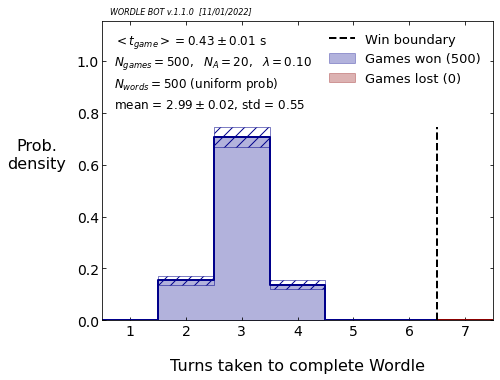

In [32]:
#  Loop over experiment configs and run

for experiment in experiments :
    print(f"Running experiment {experiment}")
    run_experiment(num_games      = experiment["num_games"     ],
                   exploit_factor = experiment["exploit_factor"], 
                   Na             = experiment["Na"            ], 
                   first_word     = experiment["first_word"    ], 
                   tag            = experiment["tag"           ])
    

In [8]:
###################################################
###  Run wordlebot for a specific example word  ###
###################################################

play_game(Na=-1, exploit_factor=0.1, true_word="NYMPH", first_word="RAISE", n_print_score=4, game_label="281")


----------------------------------------
---  BEGIN GAME 281: WORD IS 'NYMPH' ---
----------------------------------------

Turn 1
Guessing word RAISE
3193 possible guesses remain
202 possible answers remain

Turn 2
Getting score for word 3193 / 3193: ZOMBA
Top words are:
  1. COLBY (0.8694 +- 0.0018)
  2. BLUNT (0.8671 +- 0.0017)
  3. MULCH (0.8664 +- 0.0019)
  4. CLUNG (0.8661 +- 0.0021)
Guessing word COLBY
3192 possible guesses remain
1 possible answers remain

Turn 3
Guessing word NYMPH
SUCCESS IN 3 TURNS and 172.77s

Wordlebot 281 3/6

⬛⬛⬛⬛⬛
⬛⬛⬛⬛🟨
🟩🟩🟩🟩🟩


(3, 172.7710018157959)

In [ ]:

possible_guesses = initialise_possible_guesses()
possible_answers = initialise_possible_answers()

total_constraints = [[], [(1,"I"), (2,"I"), (2,"N"), (3,"B"), (4,"E"), (5,"E")], ["I", "E", "N", "B"], ["R", "T", "Y", "U", "O", "A", "S", "D", "F", "H", "L", "C", "V", "M"]]
possible_answers = filter_possible_answers(possible_answers, total_constraints)

word_scores = get_word_scores_v1(possible_guesses, possible_answers, total_constraints, Na=-1, verbose=True, exploit_factor=0.5)

